## Methods and import

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import xlrd
import numpy as np
import matplotlib.ticker as mtick

from matplotlib_venn import venn2, venn3
import openpyxl
import seaborn as sns
from openpyxl import load_workbook

def accession_slice(word):
    word= word.split('|')[2]
    word=word.split(':')[0]
    word=word.split('_')[0]
    return word

def group(list): #This grouping was taken from...
    grouped=[]
    nonpolar=['G','A','V','L','I','P','F','W','M']
    polar=['S','T','C','Y','N','Q']
    basic=['K','R','H']
    acidic=['D','E']
    for item in list:
        new_item=''
        for letter in item:
            if letter in nonpolar:
                new_item+='N'
            if letter in polar:
                new_item+='P'
            if letter in basic:
                new_item+='B'
            if letter in acidic:
                new_item+='A'
        grouped.append(new_item)
    return grouped

def get_letter_frequency(list):
    letters={
        'A':0,
        'G':0,
        'V':0,
        'L':0,
        'I':0,
        'P':0,
        'F':0,
        'W':0,
        'M':0,
        'S':0,
        'T':0,
        'C':0,
        'Y':0,
        'N':0,
        'Q':0,
        'K':0,
        'R':0,
        'H':0,
        'D':0,
        'E':0
    }
    for word in list:
        for letter in word:
            letters[letter] +=1
    return letters

Normal_aminoacids={ #From swissprot
        'A':8.25,
        'G':7.08,
        'V':6.86,
        'L':9.65,
        'I':5.92,
        'P':4.73,
        'F':3.68,
        'W':1.09,
        'M':2.41,
        'S':6.63,
        'T':5.35,
        'C':1.38,
        'Y':2.92,
        'N':4.06,
        'Q':3.93,
        'K':5.81,
        'R':5.53,
        'H':2.27,
        'D':5.46,
        'E':6.72
    }

## Getting Data from Excel-files

In [7]:

folder='WF'
files = os.listdir(folder)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame() # the dataframe to be analyzed 
df_tot=pd.DataFrame()  # all peptides invluding modified
df_mod=pd.DataFrame() # modified with feature>=4
stdev_amount=[] # feature>=4 unmodified
stdev_amount_mod=[] # modified with feature >=4
stdev_length=[]
stdev_mass=[]
stdev_protein=[]
stdev_tot=[]

number_of_files=0
for file in files_xlsx:
    number_of_files+=1
    data = pd.read_excel(folder+ '/' +file, 'peptide')
    stdev_tot.append(len(data.index))
    data['Accession'].fillna("Not available", inplace = True) 
    df_tot=df_tot.append(data)
    df_tot['Peptide']=df_tot['Peptide'].str.replace('[^a-zA-Z]','')
    print("# peptides in "+file+" "+str(len(data.index)))


    data = data.loc[(data['#Feature'] >= 4)]
    
    data_protein=data.copy()
    data_protein=data_protein.groupby(['Accession']).sum()
    stdev_protein.append(len(data_protein.index))

    
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    stdev_mass.append(data['Mass'].mean())
    stdev_length.append(data['Length'].mean())
    data['RT']=data['RT']/data['count']
    stdev_amount.append(len(data.index))
    print('Intra sample av length: ' + str(data['Length'].mean())+' std: '+str(data['Length'].std()))
    print('Intra sample av mass: ' + str(data['Mass'].mean())+' std: '+str(data['Mass'].std()))
    print('# of peptides with feat>=4 in '+file+': '+str(len(data.index)))
    df = df.append(data)  # appends all data


df['count'] = 1
df = df.groupby(['Peptide','Accession']).sum()
df.reset_index(['Peptide'], inplace=True)

df['N-cut']=df['Peptide'].apply(lambda x: x[0:4])
df['C-cut']=df['Peptide'].apply(lambda x: x[-4::1])
df['First aa']=df['Peptide'].apply(lambda x: x[0:1])
df['Last aa']=df['Peptide'].apply(lambda x: x[-1::1])

df['Spectral count']=df['#Feature']
df['Spectral count WF1']=df['#Feature WF1']
df['Spectral count WF2']=df['#Feature WF2']
df['Spectral count WF3']=df['#Feature WF 3']
df['Spectral count WF4']=df['#Feature WF4']
df['Spectral count WF5']=df['#Feature WF5']
df = df[['Peptide', 'Mass', 'Length', 'RT', 'Spectral count', 'Spectral count WF1','Spectral count WF2', 'Spectral count WF3', 'Spectral count WF4','Spectral count WF5','count', 'N-cut', 'C-cut','First aa','Last aa']]
df['Mass']=df['Mass']/df['count']
df['Length']=df['Length']/df['count']
df['RT']=df['RT']/df['count']
df = df.sort_values(['Spectral count','Accession','count'], ascending=False)

aminoacids = get_letter_frequency(df['Peptide']*df['Spectral count'])
N_aminoacids=get_letter_frequency(df['N-cut']*df['Spectral count'])
C_aminoacids=get_letter_frequency(df['C-cut']*df['Spectral count'])
First_aa=get_letter_frequency(df['First aa']*df['Spectral count'])
Last_aa=get_letter_frequency(df['Last aa']*df['Spectral count'])

print("Standard deviation total # peptides: "+str(np.std(stdev_tot, ddof=1)))
print("Standard deviation unmod and feat>=4: "+ str(np.std(stdev_amount, ddof=1)))
print("Inter-sample standard deviation length: "+ str(np.std(stdev_length, ddof=1)))
print("Inter-sample standard deviation mass: "+ str(np.std(stdev_mass, ddof=1)))
print("Standard deviation # protein: "+str(np.std(stdev_protein, ddof=1)))

print("Average length: "+str(df['Length'].mean()))
print("Average mass: "+str(df['Mass'].mean()))

print('# of peptides in all files: ' +str(sum(stdev_tot)))
df_tot=df_tot.groupby(df_tot['Peptide']).sum()
print('# of unique peptides: '+str(len(df_tot.index)))


print("# peptides with feature>=4: "+str(len(df.index))+", in percent: "+str(100*(len(df.index))/(len(df_tot.index)))+" %")

df_protein=df.copy()
df_protein.reset_index('Accession', inplace=True)
df_protein=df_protein.groupby(['Accession']).sum()
print("# of proteins: " + str(len(df_protein.index)))

df

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'WF'

KeyError: 'Peptide'

## Charts: Aminoacid profile

Text(0.5, 1.0, 'Last aminoacid')

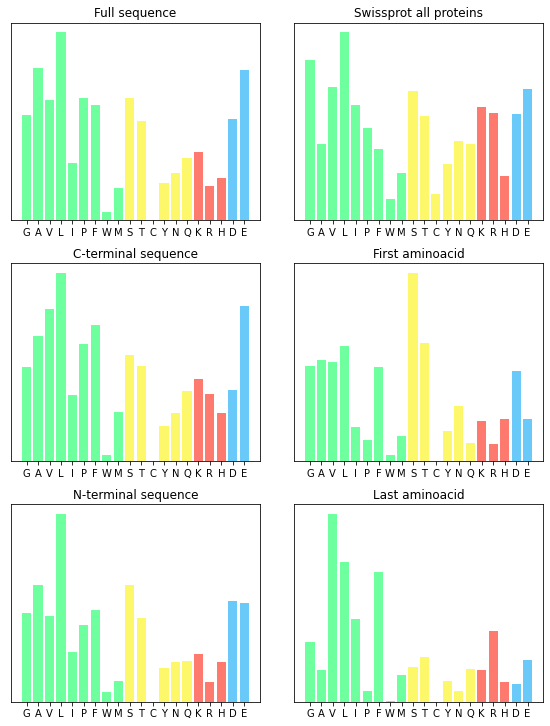

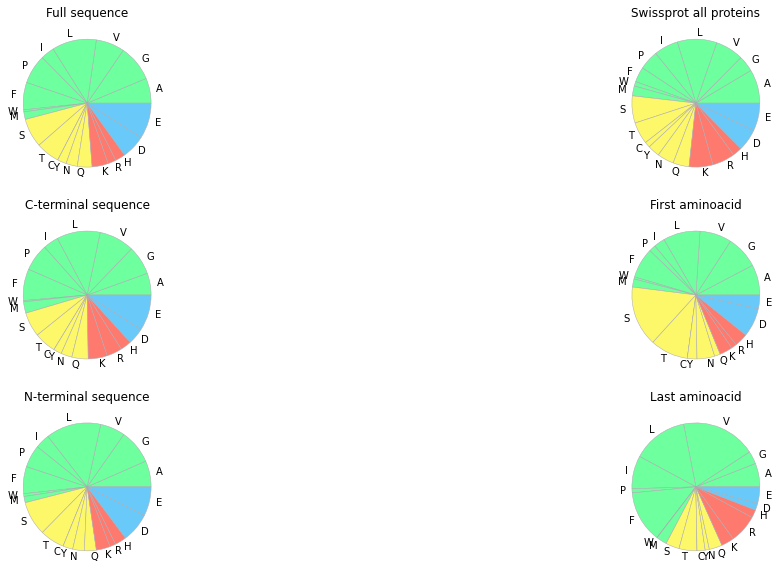

In [3]:
 
folder='protein-peptide_sample_WF' #folder which includes proximal 
files = os.listdir(folder)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_first = pd.DataFrame() # the dataframe to be analyzed 
df_last = pd.DataFrame()
df=pd.DataFrame()
number_of_files=0
for file in files_xlsx:
    data = pd.read_excel(folder+ '/' +file)
    data = data.loc[(data['#Feature'] >= 4)]
    data['Peptide']= data['Peptide'].str.replace('\d+', '')
    data['Peptide']= data['Peptide'].str.replace(r'\(\+\.\)', '')
    data['Peptide'].drop_duplicates(inplace=True)
    p_prime=[]
    p=[]
    data['Peptide'].fillna(value='Not available',inplace=True)
    for item in data['Peptide']:
        if item[-2] == '.':
            p_prime.append(item)
        if item[1]=='.':
            p.append(item)
    df=df.append(data)
    
    
df_p=pd.DataFrame(p)
df_p_prime=pd.DataFrame(p_prime)

df=df.groupby('Peptide').sum()
df_p=df_p.rename(columns={0:'Peptide'})
df_p=df_p.merge(df, on='Peptide', how='inner')
df_p_prime=df_p_prime.rename(columns={0:'Peptide'})
df_p_prime=df_p_prime.merge(df, on='Peptide', how='inner')
df_p=df_p[['Peptide','#Feature']]
df_p_prime=df_p_prime[['Peptide','#Feature']]
df_p['First aa']=df_p['Peptide'].apply(lambda x: x[2])
df_p_prime['Last aa']=df_p_prime['Peptide'].apply(lambda x: x[-3])
First_aa=get_letter_frequency(df_p['First aa']*df_p['#Feature'])
Last_aa=get_letter_frequency(df_p_prime['Last aa']*df_p_prime['#Feature'])
fig, ax = plt.subplots(1,2,figsize=(20,10))
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
color=['#e4f8c7', '#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#e4f8c7','#ffc561','#ffc561','#ffc561','#ffc561','#ffc561','#ffc561','#f93b3b','#f93b3b','#f93b3b','#34cceb','#34cceb','#34cceb']
ax[0].pie(First_aa.values(),labels = First_aa.keys(), colors=color, wedgeprops=wp) 
ax[1].pie(Last_aa.values(),labels = Last_aa.keys(), colors=color, wedgeprops=wp) 
print(First_aa)
print(Last_aa)

## Graph: Feature over count

[ 5.83630578 -2.05895298]
0.6928942160318461


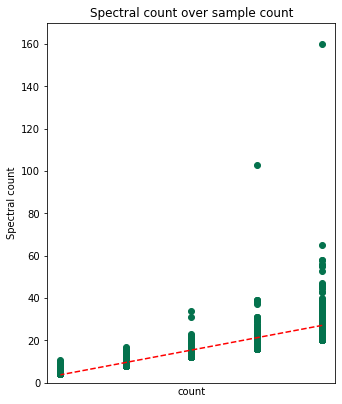

In [14]:
fig=plt.figure(figsize=(4,5), frameon=False)
ax=fig.add_axes([0,0,1,1])
ax.scatter(df['count'], df['Spectral count'], color='#04724d')
z = np.polyfit(df['count'], df['Spectral count'], 1)
p = np.poly1d(z)
ax.set_xlabel('count')
ax.set_ylabel('Spectral count')
ax.set_title('Spectral count over sample count')
plt.plot(df['count'],p(df['count']),"r--")
plt.setp(ax, ylim=(0,170))
ax.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)


correlation_matrix = np.corrcoef(df['count'], df['Spectral count'])
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print(z)
print(r_squared)

## Table: Sorted on spectral count

In [5]:
df.sort_values(['Spectral count'], ascending=False).head()

,Peptide,Mass,Length,RT,Spectral count,Spectral count WF1,Spectral count WF2,Spectral count WF3,Spectral count WF4,Spectral count WF5,count,N-cut,C-cut,First aa,Last aa
Accession,,,,,,,,,,,,,,,
sp|Q04206|TF65_HUMAN,PSLQAPVR,866.4974,8.0,14.880000,160,23.0,8.0,38.0,52.0,38.0,5,PSLQ,APVR,P,R
sp|P01009|A1AT_HUMAN,AVLTIDEKGTEAAGAMF,1738.8447,17.0,67.552500,103,6.0,0.0,47.0,12.0,38.0,4,AVLT,GAMF,A,F
sp|P04406|G3P_HUMAN,AVGKVIPELNGKLTGMAF,1860.6082,18.0,73.212000,65,12.0,12.0,16.0,18.0,7.0,5,AVGK,GMAF,A,F
sp|Q14624|ITIH4_HUMAN,NFRPGVL,802.0401,7.0,41.191000,58,13.0,13.0,14.0,6.0,12.0,5,NFRP,PGVL,N,L
sp|P06727|APOA4_HUMAN,NHQLEGLTF,1058.2737,9.0,66.895667,58,9.0,11.0,10.0,15.0,13.0,5,NHQL,GLTF,N,F


## Table: Sorted on spectral count of N/C-terminals

In [15]:

df_N=df.groupby(['N-cut']).sum()
df_N=df_N.sort_values(['count'], ascending=False)
df_N=df_N.drop(['Mass','Length','RT'], axis=1)
df_N['Spectral count']=df_N['Spectral count']/number_of_files
df_N=df_N.sort_values(['Spectral count'], ascending=False)
df_C=df.groupby(['C-cut']).sum()
df_C=df_C.drop(['Mass','Length','RT'], axis=1)
df_C['Spectral count']=df_C['Spectral count']/number_of_files
df_C=df_C.sort_values(['Spectral count'], ascending=False)


C_std=df_C.copy()
C_std=C_std.drop(['Spectral count','count'], axis=1)
df_C['std']=C_std.std(axis=1, ddof=1, numeric_only=True)

N_std=df_N.copy()
N_std=N_std.drop(['Spectral count','count'], axis=1)
df_N['std']=N_std.std(axis=1, ddof=1, numeric_only=True)
df_C

,Spectral count,Spectral count WF1,Spectral count WF2,Spectral count WF3,Spectral count WF4,Spectral count WF5,count,std
C-cut,,,,,,,,
KGEE,55.4,58.0,56.0,60.0,41.0,62.0,45,8.354639
RMFL,52.8,56.0,48.0,79.0,24.0,57.0,38,19.791412
FERI,48.8,50.0,57.0,37.0,35.0,65.0,42,12.853015
GEFV,45.2,48.0,46.0,57.0,42.0,33.0,47,8.757854
PDHA,41.0,50.0,59.0,44.0,25.0,27.0,28,14.713939
...,...,...,...,...,...,...,...,...
NGTV,0.8,4.0,0.0,0.0,0.0,0.0,1,1.788854
EQGR,0.8,0.0,4.0,0.0,0.0,0.0,1,1.788854
NELR,0.8,0.0,0.0,0.0,0.0,4.0,1,1.788854


## Graph: N/C-terminal over spectral count

1210
1072


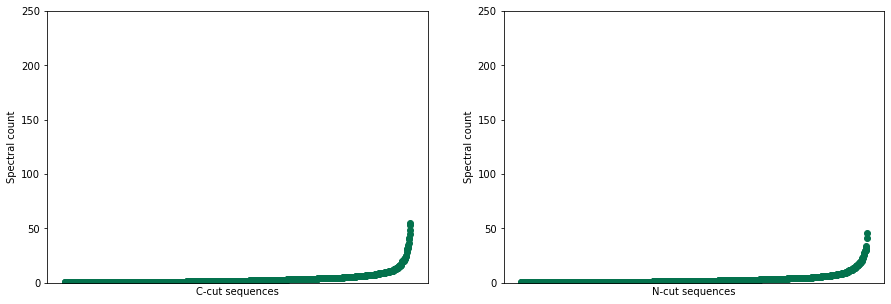

In [16]:
#These graphs show how the variation of N/C-GROUPS vary in a sample. As seen, it's not linear but exponential.

df_C=df.groupby(['C-cut']).sum()
df_N=df.groupby(['N-cut']).sum()
df_N=df_N.sort_values('Spectral count')
df_C=df_C.sort_values('Spectral count')
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut sequences')
ax[1].set_xlabel('N-cut sequences')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
plt.setp(ax, ylim=(0,250))
ax[1].scatter(df_N.index, df_N['Spectral count']/number_of_files, color='#04724d') #row=0, col=0, kanske mer relevant att kolla mot feature? Annars tittar vi mot "variation"
ax[0].scatter(df_C.index, df_C['Spectral count']/number_of_files, color='#04724d') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))


## Table: Sorted on grouped N/C-terminals based on non-polar, polar, acidic and basic

169
167


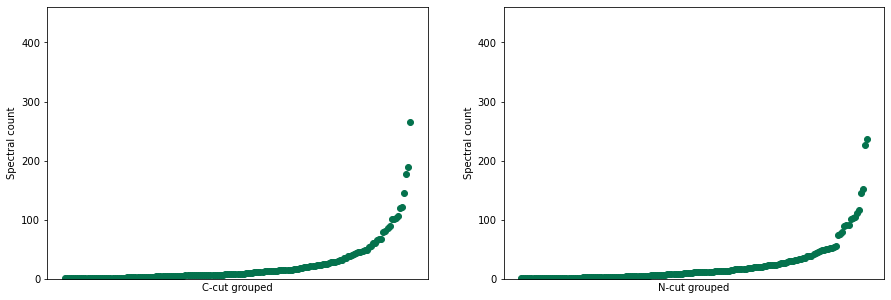

In [19]:
#This adds the N/C-grouped column when df is grouped mainly on protein, although the index is removed, and then on N/C-cutsite which is kept. 
#It is therefore still indirectly sorted on protein. There is no "respective peptide" available, although this can be easily added by sorting on Peptide aswell.

#might be an easier way to code

df_N= df.groupby(['Accession','N-cut']).sum() #groups original DataFrame by protein and n-cut. Makes protein and cut indexes
df_N = df_N.sort_values(['count','Spectral count'], ascending=False) #sorts these values by count and feature
df_N.reset_index(['Accession'], inplace=True) #removes protein from index, only cut left
df_N['N-grouped']=group(df_N.index) #creates column of N-grouped based on index, cut
df_N=df_N.drop(['Mass', 'Length','RT'], axis=1)
df_N=df_N.groupby(['N-grouped']).sum() #groups by N-grouped instead

df_N=df_N.sort_values(['count','Spectral count'], ascending=False) #sorts the grouped index on count and feature

df_C = df.groupby(['Accession','C-cut']).sum() 
df_C = df_C.sort_values(['count','Spectral count'], ascending=False)
df_C.reset_index(['Accession'], inplace=True)
df_C['C-grouped']=group(df_C.index)
df_C=df_C.drop(['Mass', 'Length','RT'], axis=1)
df_C=df_C.groupby(['C-grouped']).sum()


df_C=df_C.sort_values(['count','Spectral count'], ascending=False)
df_C.head()

## Graph: Spectral count over grouped N/C-terminal

169
167


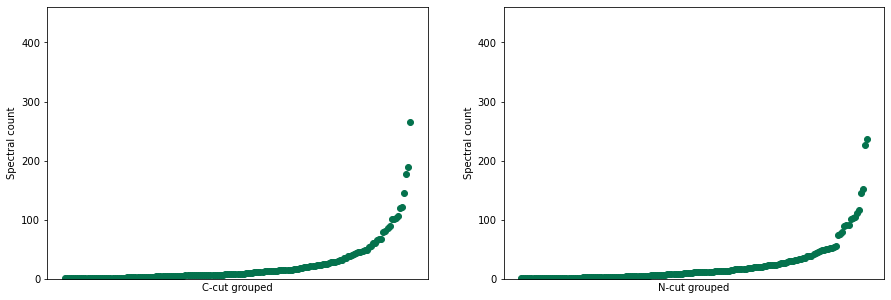

In [21]:

df_N=df_N.sort_values(['Spectral count'], ascending=True)
df_C=df_C.sort_values(['Spectral count'], ascending=True)
fig, ax = plt.subplots(1,2, figsize=(15,5))
plt.setp(ax, ylim=(0,460))
ax[1].set_xticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xlabel('C-cut grouped')
ax[1].set_xlabel('N-cut grouped')
ax[0].set_ylabel('Spectral count')
ax[1].set_ylabel('Spectral count')
ax[1].scatter(df_N.index, df_N['Spectral count'], color='#04724d') #row=0, col=0
ax[0].scatter(df_C.index, df_C['Spectral count'], color='#04724d') #row=1, col=0
ax[0].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
ax[1].tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
print(len(df_N.index))
print(len(df_C.index))


In [23]:
folder='WF'
files = os.listdir(folder)

files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_WF = pd.DataFrame()
WF_samples=[]
for file in files_xlsx:
    data = pd.read_excel(folder+ '/' +file, 'peptide')
    data['Accession'].fillna("Not available", inplace = True) 
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data = data.loc[(data['#Feature'] >= 4)]
    data['count']=1
    data = data.groupby(['Peptide','Accession'], as_index=False).sum() 
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    df_WF = df_WF.append(data)  # appends all data
    print(file+': '+str(len(data['Peptide'])))
    WF_samples.append(data['Peptide'])

folder='peptide_sample_ninf'
files = os.listdir(folder)

files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_ninf = pd.DataFrame()
non_inf_patients=[]
for file in files_xlsx:
    data = pd.read_excel(folder+ '/' +file, 'peptide')
    data['Accession'].fillna("Not available", inplace = True) 
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.loc[(data['#Feature'] >= 4)] 
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    df_ninf = df_ninf.append(data)  # appends all data
    non_inf_patients.append(data['Peptide'])

folder='peptide_sample_inf'
files = os.listdir(folder)

files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_inf = pd.DataFrame()
inf_patients=[]
for file in files_xlsx:
    data = pd.read_excel(folder+ '/' +file, 'peptide')
    data['Accession'].fillna("Not available", inplace = True) 
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.loc[(data['#Feature'] >= 4)] 
    data = data.groupby(['Peptide','Accession'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    df_inf = df_inf.append(data)  # appends all data
    inf_patients.append(data['Peptide'])

df_ninf['count'] = 1
df_WF['count'] = 1
df_inf['count']=1


peptide _WF1.xlsx: 811
peptide_WF2.xlsx: 934
peptide_WF3.xlsx: 900
peptide_WF4.xlsx: 572
peptide_WF5.xlsx: 846


In [25]:
g=(0.4, 0.7607843137254902, 0.6470588235294118)
r=(0.9882352941176471, 0.5529411764705883, 0.3843137254901961)
l=(0.5529411764705883, 0.6274509803921569, 0.796078431372549)
p=(0.9058823529411765, 0.5411764705882353, 0.7647058823529411)
lg=(0.6509803921568628, 0.8470588235294118, 0.32941176470588235)
y=(1.0, 0.8509803921568627, 0.1843137254901961)

color=[r,p,y]

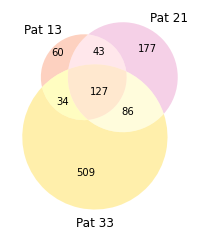

In [36]:
venn3([set(non_inf_patients[0]),set(non_inf_patients[1]),set(non_inf_patients[2])], set_labels=('Pat 13','Pat 21','Pat 33'), set_colors=color)

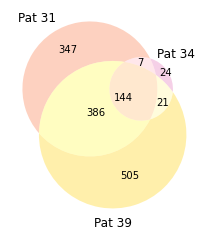

In [27]:
venn3([set(inf_patients[0]),set(inf_patients[1]),set(inf_patients[2])], set_labels=('Pat 31', 'Pat 34','Pat 39'), set_colors=color)

In [29]:
#Wf
df_WF_all=pd.DataFrame()
df_WF_all['Peptide']=df_WF['Peptide']
df_WF = df_WF.groupby(['Accession','Peptide']).sum()
df_WF.reset_index(['Peptide'], inplace=True)
df_WF = df_WF[['Peptide', '#Feature', '#Feature WF1','#Feature WF2', '#Feature WF 3', '#Feature WF4','#Feature WF5','count']]
df_WF = df_WF.sort_values(['count','#Feature'], ascending=False)

#Non-infected patients
df_ninf_all=pd.DataFrame()
df_ninf_all['Peptide']=df_ninf['Peptide']

df_ninf = df_ninf.groupby(['Accession','Peptide']).sum()
df_ninf.reset_index(['Peptide'], inplace=True)
df_ninf = df_ninf[['Peptide','#Feature','#Feature Sample 13', '#Feature Sample 21', '#Feature Sample 33','count',]]
df_ninf = df_ninf.sort_values(['count','#Feature'], ascending=False)

#infected patients
df_inf_all=pd.DataFrame()
df_inf_all['Peptide']=df_inf['Peptide']

df_inf = df_inf.groupby(['Accession','Peptide']).sum()
df_inf.reset_index(['Peptide'], inplace=True)
df_inf = df_inf[['Peptide','#Feature','#Feature Sample 31', '#Feature Sample 34', '#Feature Sample 39','count',]]
df_inf = df_inf.sort_values(['count','#Feature'], ascending=False)

In [32]:
df_ninf_same=df_ninf.loc[(df_ninf['count']==3)]
df_WF_same=df_WF.loc[(df_WF['count']==5)]
df_inf_same=df_inf.loc[(df_inf['count']==3)]

df_WF_ninf=df_WF_same.append(df_ninf_same)
df_WF_ninf.reset_index()
df_WF_ninf=df_WF_ninf.groupby(['Accession','Peptide']).sum()
df_WF_ninf.sort_values(['count','#Feature'], ascending=False)
df_WF_same.head()

,Peptide,#Feature,#Feature WF1,#Feature WF2,#Feature WF 3,#Feature WF4,#Feature WF5,count
Accession,,,,,,,,
sp|Q04206|TF65_HUMAN,PSLQAPVR,160,23.0,8.0,38.0,52.0,38.0,5
sp|P04406|G3P_HUMAN,AVGKVIPELNGKLTGMAF,65,12.0,12.0,16.0,18.0,7.0,5
sp|P06727|APOA4_HUMAN,NHQLEGLTF,58,9.0,11.0,10.0,15.0,13.0,5
sp|Q14624|ITIH4_HUMAN,NFRPGVL,58,13.0,13.0,14.0,6.0,12.0,5
sp|Q14624|ITIH4_HUMAN,SRQLGLPGPPDVPDHA,56,12.0,14.0,11.0,8.0,11.0,5


In [33]:
df_ninf_inf=df_ninf_same.append(df_inf_same)
df_ninf_inf.reset_index()
df_ninf_inf=df_ninf_inf.groupby(['Accession','Peptide']).sum()
df_ninf_inf=df_ninf_inf.sort_values(['count','#Feature'], ascending=False)
df_ninf_inf['Fold Change']=(df_ninf_inf['#Feature Sample 31']+df_ninf_inf['#Feature Sample 34']+df_ninf_inf['#Feature Sample 39'])/(df_ninf_inf['#Feature Sample 13']+df_ninf_inf['#Feature Sample 21']+df_ninf_inf['#Feature Sample 33'])
df_ninf_inf['Difference (ninf-inf)']=((df_ninf_inf['#Feature Sample 13']+df_ninf_inf['#Feature Sample 21']+df_ninf_inf['#Feature Sample 33'])/3)-((df_ninf_inf['#Feature Sample 31']+df_ninf_inf['#Feature Sample 34']+df_ninf_inf['#Feature Sample 39'])/3)
df_ninf_inf=df_ninf_inf.sort_values(['Difference (ninf-inf)'], ascending=True)
df_ninf_inf.reset_index(inplace=True)
df_ninf_inf['std ninf']=df_ninf_inf[['#Feature Sample 13', '#Feature Sample 21', '#Feature Sample 33']].std(axis = 1, ddof=1, skipna = True) 
df_ninf_inf['std inf']=df_ninf_inf[['#Feature Sample 31', '#Feature Sample 34', '#Feature Sample 39']].std(axis = 1, ddof=1, skipna = True)
df_ninf_inf.head()

,Accession,Peptide,#Feature,#Feature Sample 13,#Feature Sample 21,#Feature Sample 33,count,#Feature Sample 31,#Feature Sample 34,#Feature Sample 39,Fold Change,Difference (ninf-inf),std ninf,std inf
0,sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,AGVANALAHKYH,150,11.0,12.0,18.0,6,37.0,12.0,60.0,2.658537,-22.666667,3.785939,24.006943
1,sp|P68871|HBB_HUMAN:sp|P02042|HBD_HUMAN,GVANALAHKYH,152,13.0,13.0,17.0,6,42.0,12.0,55.0,2.534884,-22.000000,2.309401,22.052967
2,sp|P68871|HBB_HUMAN,SDGLAHLDNLKGTFA,56,0.0,0.0,0.0,3,22.0,6.0,28.0,inf,-18.666667,0.000000,11.372481
3,sp|P68871|HBB_HUMAN,VHLTPEEKSAV,102,8.0,8.0,8.0,6,28.0,14.0,36.0,3.250000,-18.000000,0.000000,11.135529
4,sp|P69905|HBA_HUMAN,AHVDDMPNALSAL,54,0.0,0.0,0.0,3,22.0,13.0,19.0,inf,-18.000000,0.000000,4.582576


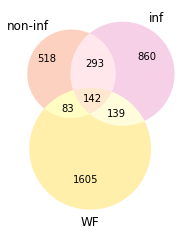

In [35]:
venn3([set(df_ninf['Peptide']), set(df_inf['Peptide']), set(df_WF['Peptide'])], set_labels = ('non-inf', 'inf', 'WF'), set_colors=color)

# Heatmap

In [ ]:
mapp='peptide_sample_inf'
files = os.listdir(mapp)
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_inf = pd.DataFrame()
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    data.dropna(subset=['Accession'], inplace=True, how='any')
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['Accession']=data['Accession'].apply(lambda x: slicydicy(x))
    data['count']=1
    data = data.loc[(data['#Feature'] >= 4)] 
    data = data.groupby(['Peptide'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    df_inf = df_inf.append(data)  # appends all data


df_inf['count']=1
df_inf= df_inf.groupby(['Peptide'], as_index=False).sum()
df_inf = df_inf[['Peptide','#Feature','#Feature Sample 31', '#Feature Sample 34', '#Feature Sample 39','count',]]
df_inf = df_inf.sort_values(['Peptide'])


mapp='WF'
files = os.listdir(mapp)
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_WF = pd.DataFrame()
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    data.dropna(subset=['Accession'], inplace=True, how='any')
    data['Accession']=data['Accession'].apply(lambda x: slicydicy(x))
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.loc[(data['#Feature'] >= 4)] 
    data = data.groupby(['Peptide'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    df_WF = df_WF.append(data)  # appends all data


df_WF['count']=1
df_WF= df_WF.groupby(['Peptide'], as_index=False).sum()
df_WF = df_WF[['Peptide', '#Feature', '#Feature WF1','#Feature WF2', '#Feature WF 3', '#Feature WF4','#Feature WF5','count']]
df_WF = df_WF.sort_values(['Peptide'])
df_WF

mapp='peptide_sample_ninf'
files = os.listdir(mapp)
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_ninf = pd.DataFrame()
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    data.dropna(subset=['Accession'], inplace=True, how='any')
    data['Accession']=data['Accession'].apply(lambda x: slicydicy(x))
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data['count']=1
    data = data.loc[(data['#Feature'] >= 4)]
    data = data.groupby(['Peptide'], as_index=False).sum()
    data['Mass']=data['Mass']/data['count']
    data['Length']=data['Length']/data['count']
    data['RT']=data['RT']/data['count']
    df_ninf = df_ninf.append(data)  # appends all data


df_ninf['count']=1
df_ninf= df_ninf.groupby(['Peptide'], as_index=False).sum()
df_ninf = df_ninf[['Peptide','#Feature','#Feature Sample 13', '#Feature Sample 21', '#Feature Sample 33','count',]]
df_ninf = df_ninf.sort_values(['Peptide'])
df_inf

In [37]:
heatmap_inf=pd.read_excel('heatmap.xlsx',sheet_name='inf')
heatmap_ninf=pd.read_excel('heatmap.xlsx',sheet_name='ninf')
heatmap_WF=pd.read_excel('heatmap.xlsx',sheet_name='WF')

heatmap_ninf=heatmap_ninf.rename(columns={'Seq':'Peptide'})
heatmap_inf=heatmap_inf.rename(columns={'Seq':'Peptide'})
heatmap_WF=heatmap_WF.rename(columns={'Seq':'Peptide'})


In [38]:
heatmap_inf=heatmap_inf.merge(df_inf, on='Peptide', how='inner')
heatmap_ninf=heatmap_ninf.merge(df_ninf, on='Peptide', how='inner')
heatmap_WF=heatmap_WF.merge(df_WF, on='Peptide', how='inner')
heatmap_inf.head()

,Seq ID,Peptide,Anti-Microbial,Deep-AmPEP30,RF-AmPEP30,#Feature,#Feature Sample 31,#Feature Sample 34,#Feature Sample 39,count
0,0,AAHLPAEF,0.43,0.210585,0.464167,4,4.0,0.0,0.0,1
1,1,AAHLPAEFTPA,0.35,0.214085,0.425833,8,4.0,0.0,4.0,2
2,2,AAHLPAEFTPAV,0.51,0.301519,0.452500,12,4.0,4.0,4.0,3
3,3,AAHLPAEFTPAVH,0.45,0.330300,0.465000,19,7.0,4.0,8.0,3
4,4,AAHLPAEFTPAVHA,0.44,0.403371,0.500833,23,8.0,4.0,11.0,3
...,...,...,...,...,...,...,...,...,...,...
1456,1429,YQKVVAGVAN,0.76,0.524316,0.435000,4,0.0,0.0,4.0,1
1457,1430,YQKVVAGVANA,0.79,0.591136,0.434167,4,0.0,0.0,4.0,1
1458,1431,YQKVVAGVANAL,0.81,0.550833,0.433333,8,4.0,0.0,4.0,2
1459,1432,YQKVVAGVANALA,0.82,0.559647,0.462500,4,4.0,0.0,0.0,1


In [40]:
cutoff=0.7
heatmap_WF=heatmap_WF.loc[(heatmap_WF['Deep-AmPEP30']>=cutoff)]
heatmap_inf=heatmap_inf.loc[(heatmap_inf['Deep-AmPEP30']>=cutoff)]
heatmap_ninf=heatmap_ninf.loc[(heatmap_ninf['Deep-AmPEP30']>=cutoff)]
heatmap_inf.sort_values('#Feature', ascending=False)

,Seq ID,Peptide,Anti-Microbial,Deep-AmPEP30,RF-AmPEP30,#Feature,#Feature Sample 31,#Feature Sample 34,#Feature Sample 39,count
529,521,GVANALAHKYH,0.51,0.890835,0.594167,109,42.0,12.0,55.0,3
70,67,AGVANALAHKYH,0.11,0.892151,0.613333,109,37.0,12.0,60.0,3
129,126,ANALAHKYH,0.11,0.808967,0.600000,94,33.0,9.0,52.0,3
841,827,NALAHKYH,0.07,0.804693,0.592500,57,17.0,4.0,36.0,3
1258,1233,VAGVANALAHKYH,0.39,0.895293,0.646667,53,17.0,8.0,28.0,3
...,...,...,...,...,...,...,...,...,...,...
1083,1065,SLPLPNFS,0.42,0.711014,0.525833,4,0.0,0.0,4.0,1
631,623,KAAWGKVGAHA,0.77,0.802453,0.807500,4,4.0,0.0,0.0,1
842,828,NALWGKV,0.32,0.770976,0.712500,4,4.0,0.0,0.0,1
629,621,KAAWGKV,0.49,0.812796,0.804167,4,4.0,0.0,0.0,1


In [44]:

heatmap_inf['AMS1']=heatmap_inf['#Feature Sample 31']*heatmap_inf['Deep-AmPEP30']
heatmap_inf['AMS2']=heatmap_inf['#Feature Sample 34']*heatmap_inf['Deep-AmPEP30']
heatmap_inf['AMS3']=heatmap_inf['#Feature Sample 39']*heatmap_inf['Deep-AmPEP30']

heatmap_ninf['AMS1']=heatmap_ninf['#Feature Sample 13']*heatmap_ninf['Deep-AmPEP30']
heatmap_ninf['AMS2']=heatmap_ninf['#Feature Sample 21']*heatmap_ninf['Deep-AmPEP30']
heatmap_ninf['AMS3']=heatmap_ninf['#Feature Sample 33']*heatmap_ninf['Deep-AmPEP30']

heatmap_WF['AMS1']=heatmap_WF['#Feature WF1']*heatmap_WF['Deep-AmPEP30']
heatmap_WF['AMS2']=heatmap_WF['#Feature WF2']*heatmap_WF['Deep-AmPEP30']
heatmap_WF['AMS3']=heatmap_WF['#Feature WF 3']*heatmap_WF['Deep-AmPEP30']
heatmap_WF['AMS4']=heatmap_WF['#Feature WF4']*heatmap_WF['Deep-AmPEP30']
heatmap_WF['AMS5']=heatmap_WF['#Feature WF5']*heatmap_WF['Deep-AmPEP30']

heatmap_WF.head()

,Seq ID,Peptide,Anti-Microbial,Deep-AmPEP30,RF-AmPEP30,#Feature,#Feature WF1,#Feature WF2,#Feature WF 3,#Feature WF4,#Feature WF5,count,AMS1,AMS2,AMS3,AMS4,AMS5,std,mean AMS
1578,1527,STGKTFPGFFSPMLGEFV,0.70,0.846377,0.530833,26,6.0,5.0,4.0,6.0,5.0,5,5.078262,4.231885,3.385508,5.078262,4.231885,0.708130,4.401160
1993,1929,YFPHFDLSHG,0.51,0.708865,0.421667,30,9.0,8.0,6.0,0.0,7.0,4,6.379785,5.670920,4.253190,0.000000,4.962055,2.506216,4.253190
1097,1059,MFLSFPTTK,0.66,0.890868,0.548333,20,4.0,4.0,4.0,4.0,4.0,5,3.563472,3.563472,3.563472,3.563472,3.563472,0.000000,3.563472
411,401,FFDTASTGKTFPGFFSPML,0.40,0.791128,0.447500,22,5.0,0.0,6.0,5.0,6.0,4,3.955640,0.000000,4.746768,3.955640,4.746768,1.985716,3.480963
608,591,GKTFPGFFSPML,0.60,0.856436,0.572500,19,4.0,6.0,4.0,0.0,5.0,4,3.425744,5.138616,3.425744,0.000000,4.282180,1.952975,3.254457


In [43]:
ninf_std=heatmap_ninf.copy()
ninf_std=ninf_std[['AMS1', 'AMS2','AMS3']]
heatmap_ninf['std']=ninf_std.std(axis=1, ddof=1, numeric_only=True)
heatmap_ninf['mean AMS']=ninf_std.mean(axis=1, numeric_only=True)
heatmap_ninf=heatmap_ninf.sort_values('mean AMS', ascending=False)

WF_std=heatmap_WF.copy()
WF_std=WF_std[['AMS1', 'AMS2','AMS3','AMS4','AMS5']]
heatmap_WF['std']=WF_std.std(axis=1, ddof=1, numeric_only=True)
heatmap_WF['mean AMS']=WF_std.mean(axis=1, numeric_only=True)
heatmap_WF=heatmap_WF.sort_values('mean AMS', ascending=False)

inf_std=heatmap_inf.copy()
inf_std=inf_std[['AMS1', 'AMS2','AMS3']]
heatmap_inf['std']=inf_std.std(axis=1, ddof=1, numeric_only=True)
heatmap_inf['mean AMS']=inf_std.mean(axis=1, numeric_only=True)
heatmap_inf=heatmap_inf.sort_values('mean AMS', ascending=False)
heatmap_WF.head()

,Seq ID,Peptide,Anti-Microbial,Deep-AmPEP30,RF-AmPEP30,#Feature,#Feature WF1,#Feature WF2,#Feature WF 3,#Feature WF4,#Feature WF5,count,AMS1,AMS2,AMS3,AMS4,AMS5,std,mean AMS
1578,1527,STGKTFPGFFSPMLGEFV,0.70,0.846377,0.530833,26,6.0,5.0,4.0,6.0,5.0,5,5.078262,4.231885,3.385508,5.078262,4.231885,0.708130,4.401160
1993,1929,YFPHFDLSHG,0.51,0.708865,0.421667,30,9.0,8.0,6.0,0.0,7.0,4,6.379785,5.670920,4.253190,0.000000,4.962055,2.506216,4.253190
1097,1059,MFLSFPTTK,0.66,0.890868,0.548333,20,4.0,4.0,4.0,4.0,4.0,5,3.563472,3.563472,3.563472,3.563472,3.563472,0.000000,3.563472
411,401,FFDTASTGKTFPGFFSPML,0.40,0.791128,0.447500,22,5.0,0.0,6.0,5.0,6.0,4,3.955640,0.000000,4.746768,3.955640,4.746768,1.985716,3.480963
608,591,GKTFPGFFSPML,0.60,0.856436,0.572500,19,4.0,6.0,4.0,0.0,5.0,4,3.425744,5.138616,3.425744,0.000000,4.282180,1.952975,3.254457


In [46]:
amount_of_sequences=50

WF_AMS1=heatmap_WF['AMS1'].sort_values(ascending=False)[0:amount_of_sequences]
WF_AMS2=heatmap_WF['AMS2'].sort_values(ascending=False)[0:50]
WF_AMS3=heatmap_WF['AMS3'].sort_values(ascending=False)[0:50]
WF_AMS4=heatmap_WF['AMS4'].sort_values(ascending=False)[0:50]
WF_AMS5=heatmap_WF['AMS5'].sort_values(ascending=False)[0:50]

inf_AMS1=heatmap_inf['AMS1'].sort_values(ascending=False)[0:amount_of_sequences]
inf_AMS2=heatmap_inf['AMS2'].sort_values(ascending=False)[0:amount_of_sequences]
inf_AMS3=heatmap_inf['AMS3'].sort_values(ascending=False)[0:amount_of_sequences]

ninf_AMS1=heatmap_ninf['AMS1'].sort_values(ascending=False)[0:amount_of_sequences]
ninf_AMS2=heatmap_ninf['AMS2'].sort_values(ascending=False)[0:amount_of_sequences]
ninf_AMS3=heatmap_ninf['AMS3'].sort_values(ascending=False)[0:amount_of_sequences]


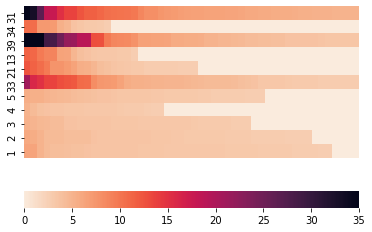

In [47]:

ytick=['31','34','39','13','21','33','5','4','3','2','1'] #sample order
ax = sns.heatmap([inf_AMS1, inf_AMS2, inf_AMS3,ninf_AMS1, ninf_AMS2, ninf_AMS3, WF_AMS5, WF_AMS4, WF_AMS3, WF_AMS2, WF_AMS1], vmin=0, vmax=35,cmap="rocket_r", yticklabels=ytick, xticklabels=False, cbar_kws={"orientation": "horizontal"})
fig = ax.get_figure()
#fig.savefig("heatmap.svg", transparent=True)

In [51]:
AMS1=sum(heatmap_WF['AMS1'])
AMS2=sum(heatmap_WF['AMS2'])
AMS3=sum(heatmap_WF['AMS3'])
AMS4=sum(heatmap_WF['AMS4'])
AMS5=sum(heatmap_WF['AMS5'])
print('WF: ',AMS1, AMS2, AMS3, AMS4, AMS5)

AMS_mean=np.mean([AMS1, AMS2, AMS3, AMS4, AMS5])
AMS_std=np.std([AMS1, AMS2, AMS3, AMS4, AMS5], ddof=1)
print(AMS_mean, AMS_std)

AMS1=sum(heatmap_inf['AMS1'])
AMS2=sum(heatmap_inf['AMS2'])
AMS3=sum(heatmap_inf['AMS3'])

print('Infected: ',AMS1, AMS2, AMS3)

AMS_mean=np.mean([AMS1, AMS2, AMS3])
AMS_std=np.std([AMS1, AMS2, AMS3], ddof=1)
print(AMS_mean, AMS_std)

AMS1=sum(heatmap_ninf['AMS1'])
AMS2=sum(heatmap_ninf['AMS2'])
AMS3=sum(heatmap_ninf['AMS3'])

print('Non-infected: ',AMS1, AMS2, AMS3)

AMS_mean=np.mean([AMS1, AMS2, AMS3])
AMS_std=np.std([AMS1, AMS2, AMS3], ddof=1)
print(AMS_mean, AMS_std)

WF:  164.70652399999997 154.49354900000003 121.88631500000001 72.32371199999999 132.16172199999997
129.11436439999997 36.04724026344282
Infected:  722.86468 72.95069499999998 619.5075990000004
471.7743246666668 349.23614823437316
Non-infected:  98.75932100000001 137.60428800000003 344.92224099999993
193.76194999999998 132.3416338372444


In [52]:

folder='peptide_sample_inf'
files = os.listdir(folder)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame()
for file in files_xlsx:
    data = pd.read_excel(folder+ '/' +file, 'peptide')
    data=data.loc[data['#Feature']>=4]
    df = df.append(data)

df.dropna(subset=['Accession'], inplace=True, how='any')
df.reset_index(drop=True)
df['count'] = 1
df['Accession']=df['Accession'].apply(lambda x: accession_slice(x))
df = df.groupby(['Accession']).sum()
tot=df['#Feature'].sum()
df=df.sort_values(['#Feature'], ascending=False)[0:30]
df=df['#Feature']
df_misc=df[10:len(df)]
df_imp=df[0:10]
df_list_imp=list(df_imp)
other =df_misc.sum()
df_list_imp.append(other)
df_list_imp

[6755, 3886, 388, 317, 266, 162, 126, 124, 124, 122, 1051]

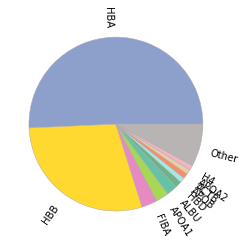

In [62]:

keys =(list(df_imp.keys()))
keys.append('Other')

g=(0.4, 0.7607843137254902, 0.6470588235294118)
r=(0.9882352941176471, 0.5529411764705883, 0.3843137254901961)
l=(0.5529411764705883, 0.6274509803921569, 0.796078431372549)
p=(0.9058823529411765, 0.5411764705882353, 0.7647058823529411)
lg=(0.6509803921568628, 0.8470588235294118, 0.32941176470588235)
y=(1.0, 0.8509803921568627, 0.1843137254901961)

rc1=('#69b584')
rc2=('#a7e8e7')
rc3=('#e8cea7')
rc4=('#f5b5bf')
rc5=('#b8b4b4')

WF_colors=[l,y,p,lg,g,rc1,rc2,r,rc3,rc4,rc5]
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
pie=plt.pie(list(df_list_imp),labels = keys , wedgeprops=wp, rotatelabels=True, colors=WF_colors) 


# Exclude HB proteins

In [3]:
def accession_slice(word):
    if '|' in word:
        word= word.split('|')[2]
        word=word.split(':')[0]
        word=word.split('_')[0]
        return word
    else:
        return word
    
    
folder='peptide_sample_ninf'
files = os.listdir(folder)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame()
for file in files_xlsx:
    data = pd.read_excel(folder+ '/' +file, 'peptide')
    data=data.loc[data['#Feature']>=4]
    df = df.append(data)

df.dropna(subset=['Accession'], inplace=True, how='any')
df.reset_index(drop=True)
df['count'] = 1
df['Accession']=df['Accession'].apply(lambda x: accession_slice(x))
df = df.groupby(['Accession']).sum()
df = df.drop(['HBB','HBA','HBD'])

tot=df['#Feature'].sum()
df=df.sort_values(['#Feature'], ascending=False)[0:30]
df=df['#Feature']
df_misc=df[10:len(df)]
df_imp=df[0:10]
df_list_imp=list(df_imp)
other =df_misc.sum()
df_list_imp.append(other)
df_list_imp

[876, 417, 381, 230, 198, 162, 123, 114, 108, 92, 904]

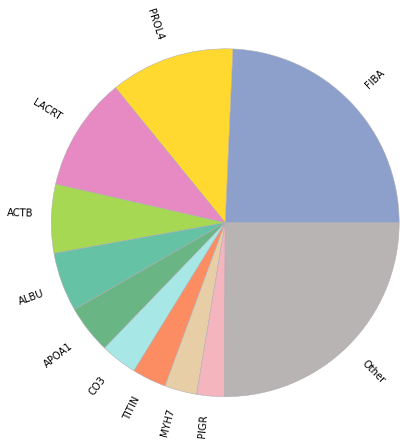

In [4]:

keys =(list(df_imp.keys()))
keys.append('Other')

g=(0.4, 0.7607843137254902, 0.6470588235294118)
r=(0.9882352941176471, 0.5529411764705883, 0.3843137254901961)
l=(0.5529411764705883, 0.6274509803921569, 0.796078431372549)
p=(0.9058823529411765, 0.5411764705882353, 0.7647058823529411)
lg=(0.6509803921568628, 0.8470588235294118, 0.32941176470588235)
y=(1.0, 0.8509803921568627, 0.1843137254901961)

rc1=('#69b584')
rc2=('#a7e8e7')
rc3=('#e8cea7')
rc4=('#f5b5bf')
rc5=('#b8b4b4')

WF_colors=[l,y,p,lg,g,rc1,rc2,r,rc3,rc4,rc5]
wp = { 'linewidth' : 0.5, 'edgecolor' : "#afabb3" } 
pie=plt.pie(list(df_list_imp),labels = keys , wedgeprops=wp, rotatelabels=True, colors=WF_colors, radius=2) 


In [ ]:
mapp='peptide_sample_ninf'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
np_list=[]
df = pd.DataFrame()
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    data.dropna(subset=['Accession'], inplace=True, how='any')
    data=data.loc[data['#Feature']>=4]
    data['count']=1
    data['Accession']=data['Accession'].apply(lambda x: slicydicy(x))
    data=data.groupby(['Accession'], as_index=False).sum()
    np_list.append(int(data.loc[(data['Accession']=='HBB')]['#Feature']))

print(np_list)
print(np.average(np_list))
print(np.std(np_list, ddof=1))

In [ ]:
mapp='peptide_sample_inf'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame()
np_list=[]
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    data.dropna(subset=['Accession'], inplace=True, how='any')
    data=data.loc[data['#Feature']>=4]
    data['count']=1
    data['Accession']=data['Accession'].apply(lambda x: slicydicy(x))
    data=data.groupby(['Accession'], as_index=False).sum()
    np_list.append(int(data.loc[(data['Accession']=='HBB')]['#Feature']))

print(np_list)
print(np.average(np_list))
print(np.std(np_list,ddof=1))

In [ ]:
mapp='peptide_sample_inf'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df = pd.DataFrame()
np_list=[]
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    data.dropna(subset=['Accession'], inplace=True, how='any')
    data=data.loc[data['#Feature']>=4]
    data['count']=1
    data['Accession']=data['Accession'].apply(lambda x: slicydicy(x))
    data=data.groupby(['Accession'], as_index=False).sum()
    np_list.append(int(data.loc[(data['Accession']=='HBB')]['#Feature']))

print(np_list)
print(np.average(np_list))
print(np.std(np_list,ddof=1))

In [63]:
mapp='WF'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_WF = pd.DataFrame()
WF_samples=[]
WF_samples_CO=[]
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    data['Accession'].fillna("Not available", inplace = True) 
    WF_samples.append(data[['Peptide','#Feature']])
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data = data.loc[(data['#Feature'] >= 4)]
    data = data.groupby(['Peptide','Accession'], as_index=False).sum() 
    
    df_WF = df_WF.append(data)  # appends all data
    print(file+': '+str(len(data['Peptide'])))
    WF_samples_CO.append(data[['Peptide','#Feature']])

mapp='peptide_sample_ninf'
files = os.listdir(mapp)
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_ninf = pd.DataFrame()
ninf_samples=[]
ninf_samples_CO=[]
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    data['Accession'].fillna("Not available", inplace = True) 
    ninf_samples.append(data[['Peptide','#Feature']])
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data = data.loc[(data['#Feature'] >= 4)]
    data = data.groupby(['Peptide','Accession'], as_index=False).sum() 
    
    df_ninf = df_ninf.append(data)  # appends all data
    print(file+': '+str(len(data['Peptide'])))
    ninf_samples_CO.append(data[['Peptide','#Feature']])

mapp='peptide_sample_inf'
files = os.listdir(mapp)
# gets all xlsx files in cwd
files_xlsx = [f for f in files if f[-4:] == 'xlsx']
df_inf = pd.DataFrame()
inf_samples=[]
inf_samples_CO=[]
for file in files_xlsx:
    data = pd.read_excel(mapp+ '/' +file, 'peptide')
    data['Accession'].fillna("Not available", inplace = True) 
    inf_samples.append(data[['Peptide','#Feature']])
    data['Peptide']=data['Peptide'].str.replace('[^a-zA-Z]','')
    data = data.loc[(data['#Feature'] >= 4)]
    data = data.groupby(['Peptide','Accession'], as_index=False).sum() 
    
    df_inf = df_inf.append(data)  # appends all data
    print(file+': '+str(len(data['Peptide'])))
    inf_samples_CO.append(data[['Peptide','#Feature']])

df_ninf['count'] = 1
df_WF['count'] = 1
df_inf['count']=1


peptide _WF1.xlsx: 811
peptide_WF2.xlsx: 934
peptide_WF3.xlsx: 900
peptide_WF4.xlsx: 572
peptide_WF5.xlsx: 846
peptide_sample_13.xlsx: 264
peptide_sample_21.xlsx: 433
peptide_sample_33.xlsx: 756
peptide_sample_31.xlsx: 884
peptide_sample_34.xlsx: 196
peptide_sample_39.xlsx: 1056


In [66]:
sum_WF_samples=[sum(WF_samples[0]['#Feature']),sum(WF_samples[1]['#Feature']),sum(WF_samples[2]['#Feature']),sum(WF_samples[3]['#Feature']),sum(WF_samples[4]['#Feature'])]
WF_samples_std=np.std(sum_WF_samples)
sum_ninf_samples=[sum(ninf_samples[0]['#Feature']),sum(ninf_samples[1]['#Feature']),sum(ninf_samples[2]['#Feature'])]
ninf_samples_std=np.std(sum_ninf_samples)
sum_inf_samples=[sum(inf_samples[0]['#Feature']),sum(inf_samples[1]['#Feature']),sum(inf_samples[2]['#Feature'])]
inf_samples_std=np.std(sum_inf_samples)

mean_WF_samples = np.mean(sum_WF_samples)
mean_inf_samples = np.mean(sum_inf_samples )
mean_ninf_samples = np.mean(sum_ninf_samples)

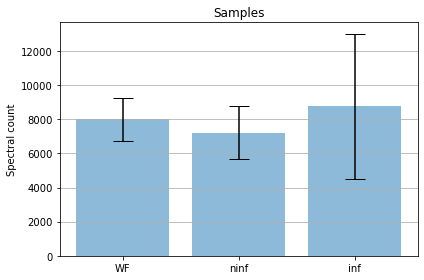

In [67]:
fig, ax = plt.subplots()

samples = ['WF', 'ninf', 'inf']
x_pos = np.arange(len(samples))
CTEs = [mean_WF_samples, mean_ninf_samples, mean_inf_samples]
error = [WF_samples_std, ninf_samples_std, inf_samples_std]

ax.bar(samples, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Spectral count')
ax.set_xticks(x_pos)
ax.set_xticklabels(samples)
ax.set_title('Samples')
ax.yaxis.grid(True)


plt.tight_layout()
plt.show()

In [68]:
sum_WF_samples_CO=[sum(WF_samples_CO[0]['#Feature']),sum(WF_samples_CO[1]['#Feature']),sum(WF_samples_CO[2]['#Feature']),sum(WF_samples_CO[3]['#Feature']),sum(WF_samples_CO[4]['#Feature'])]
WF_samples_CO_std=np.std(sum_WF_samples_CO)
sum_inf_samples_CO=[sum(inf_samples_CO[0]['#Feature']),sum(inf_samples_CO[1]['#Feature']),sum(inf_samples_CO[2]['#Feature'])]
inf_samples_CO_std=np.std(sum_inf_samples_CO)
inf_samples_CO_std
sum_ninf_samples_CO=[sum(ninf_samples_CO[0]['#Feature']),sum(ninf_samples_CO[1]['#Feature']),sum(ninf_samples_CO[2]['#Feature'])]
ninf_samples_CO_std=np.std(sum_ninf_samples_CO)
ninf_samples_CO_std
mean_WF_samples_CO = np.mean(sum_WF_samples_CO)
mean_inf_samples_CO = np.mean(sum_inf_samples_CO)
mean_ninf_samples_CO = np.mean(sum_ninf_samples_CO)

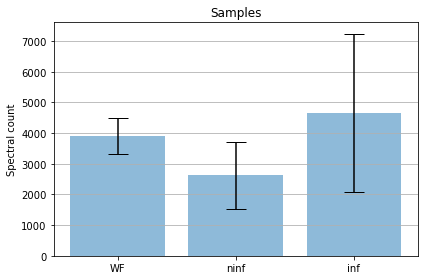

In [70]:
fig, ax = plt.subplots()
samples = ['WF', 'ninf', 'inf']
x_pos = np.arange(len(samples))
CTEs = [mean_WF_samples_CO, mean_ninf_samples_CO, mean_inf_samples_CO]
error = [WF_samples_CO_std, ninf_samples_CO_std, inf_samples_CO_std]

ax.bar(samples, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Spectral count')
ax.set_xticks(x_pos)
ax.set_xticklabels(samples)
ax.set_title('Samples')
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

In [80]:
g=(0.4, 0.7607843137254902, 0.6470588235294118)
r=(0.9882352941176471, 0.5529411764705883, 0.3843137254901961)
l=(0.5529411764705883, 0.6274509803921569, 0.796078431372549)
p=(0.9058823529411765, 0.5411764705882353, 0.7647058823529411)
lg=(0.6509803921568628, 0.8470588235294118, 0.32941176470588235)
y=(1.0, 0.8509803921568627, 0.1843137254901961)

def accession_slice(word):
    if '|' in word:
        word= word.split('|')[2]
        word=word.split(':')[0]
        word=word.split('_')[0]
        return word
    else:
        return word

sheet='inf'
df = pd.read_excel('antimicrobial_map.xlsx', sheet_name=sheet)
cutoff=0.7
df=df.loc[(df['Deep-AmPEP30']>=cutoff]
df=df[['Accession', '#Feature','Feature*Ampep,deep', 'Deep-AmPEP30']]
df['#Feature'].sum()

1695

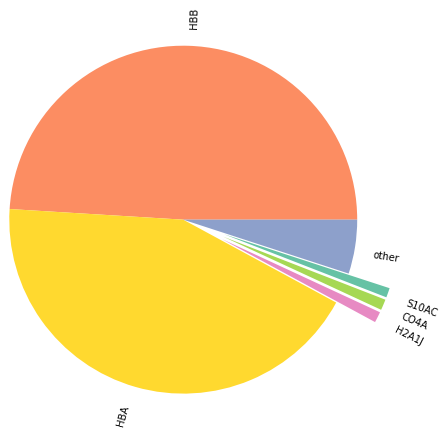

In [82]:
df['Accession']=df['Accession'].apply(lambda x: accession_slice(x))

df=df.groupby('Accession', as_index=False).sum()
df=df.sort_values('Feature*Ampep,deep', ascending=False)


df_imp=df[0:5]
df_misc=df[5:len(df)]
df_imp
df_list_imp=list(df_imp['#Feature'])
other =df_misc['#Feature'].sum()
df_list_imp.append(other)
df_list_imp
labels=df_imp['Accession'][0:5]
labels=list(labels)
labels.append('other')
colors=[r,y,p,lg,g,l]
plt.pie(df_list_imp,labels = labels , rotatelabels=True, explode=[0,0,0.5,0.5,0.5,0], radius=2, colors=colors) 
plt.show()

In [83]:
sheet='ninf'
df = pd.read_excel('antimicrobial_map.xlsx', sheet_name=sheet)
df=df.loc[(df['Deep-AmPEP30']>=cutoff)]
df=df[['Accession', '#Feature','Feature*Ampep,deep', 'Deep-AmPEP30']]
df['#Feature'].sum()

702

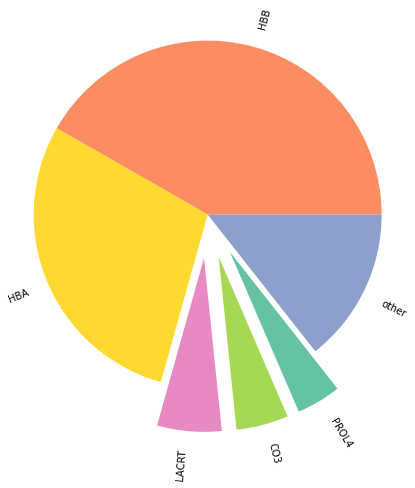

In [84]:
df['Accession']=df['Accession'].apply(lambda x: accession_slice(x))

df=df.groupby('Accession', as_index=False).sum()
df=df.sort_values('Feature*Ampep,deep', ascending=False)


df_imp=df[0:5]
df_misc=df[5:len(df)]
df_imp
df_list_imp=list(df_imp['#Feature'])
other =df_misc['#Feature'].sum()
df_list_imp.append(other)
df_list_imp
labels=df_imp['Accession'][0:5]
labels=list(labels)
labels.append('other')
colors=[r,y,p,lg,g,l]
plt.pie(df_list_imp,labels = labels , rotatelabels=True, explode=[0,0,0.5,0.5,0.5,0], radius=2, colors=colors) 
plt.show()

In [85]:
sheet='WF'
df = pd.read_excel('antimicrobial_map.xlsx', sheet_name=sheet)
df=df.loc[(df['Deep-AmPEP30']>=cutoff)]
df=df[['Accession', 'Spectral count','Feature*Ampep,deep', 'Deep-AmPEP30']]
df['Spectral count'].sum()

776

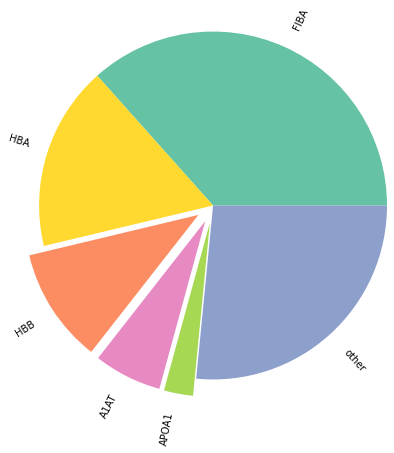

In [86]:
df['Accession']=df['Accession'].apply(lambda x: accession_slice(x))

df=df.groupby('Accession', as_index=False).sum()
df=df.sort_values('Feature*Ampep,deep', ascending=False)


df_imp=df[0:5]
df_misc=df[5:len(df)]
df_imp
df_list_imp=list(df_imp['Spectral count'])
other =df_misc['Spectral count'].sum()
df_list_imp.append(other)
df_list_imp
labels=df_imp['Accession'][0:5]
labels=list(labels)
labels.append('other')
colors=[g,y,r,p,lg,l]
plt.pie(df_list_imp,labels = labels , rotatelabels=True, explode=[0,0,0.2,0.2,0.2,0], radius=2, colors=colors) 
plt.savefig('WF_AMP_pie.svg', transparent=True, bbox_inches='tight')